# Simple trigger efficiency

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from awkward import JaggedArray
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
from FireHydrant.Tools.trigger import Triggers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.seterr(divide='ignore', invalid='ignore', over='ignore')

In [2]:
import json
datasets = json.load(open('Samples/signal_4mu.json'))

In [4]:
class TriggerProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        pt_axis = hist.Bin("pt", r"$p_T$ [GeV]", 50, 0, 200)
        trigger_axis = hist.Cat('trigger', 'triggered')
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("Counts", dataset_axis, pt_axis, trigger_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset=df['dataset']
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            px=df['dsamuon_p4.fCoordinates.fX'],
            py=df['dsamuon_p4.fCoordinates.fY'],
            pz=df['dsamuon_p4.fCoordinates.fZ'],
            energy=df['dsamuon_p4.fCoordinates.fT'],
            nsta=df['dsamuon_nStaValHits'],
            normchi2=df['dsamuon_normChi2']
        )
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        dsamuons = dsamuons[(np.abs(dsamuons.eta)<2.4)&(dsamuons.nsta>1)&(dsamuons.normchi2<10)]
        twodsa = dsamuons.counts>=2
        dsamuons = dsamuons[twodsa]
        trigger=trigger[twodsa]
        
        # subleading dsamuon
        sublidx = JaggedArray.fromfolding(dsamuons.pt.argsort()[:, 1], 1)
        subleading = dsamuons[sublidx]
        
        output['pt'].fill(dataset=dataset, trigger='true', pt=subleading[trigger].pt.flatten())
        output['pt'].fill(dataset=dataset, trigger='false', pt=subleading[~trigger].pt.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=TriggerProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=6, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 160/160 [00:29<00:00,  5.43items/s]


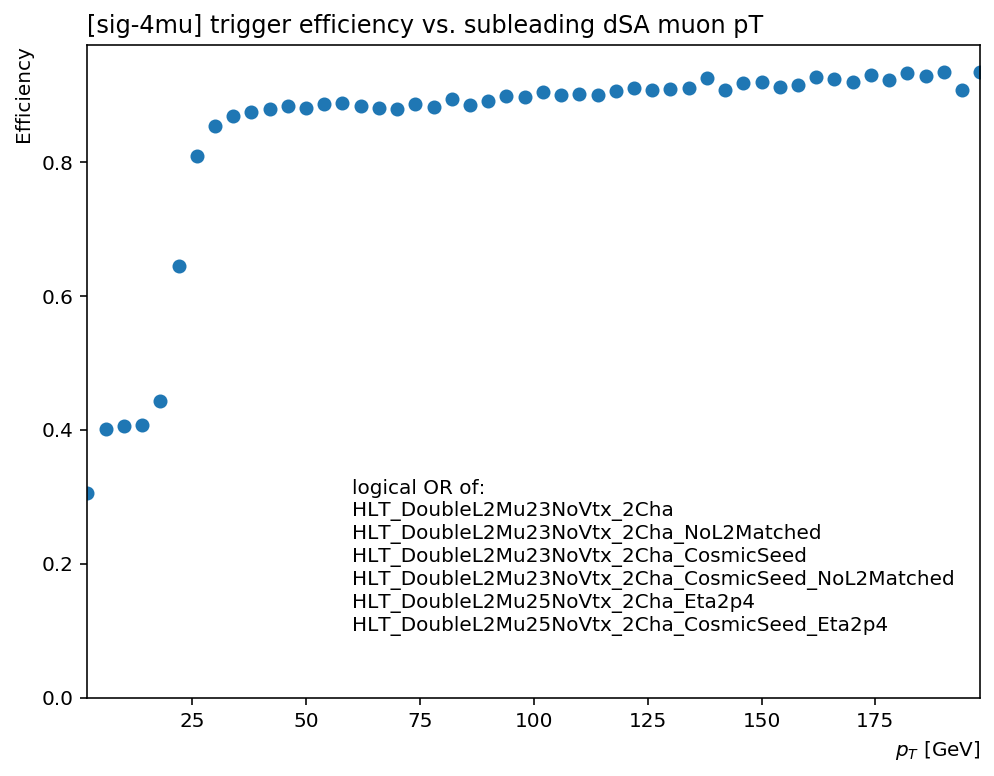

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
numer = output['pt'].project('dataset').project('trigger', 'true')
denom = output['pt'].project('dataset').sum('trigger')

fig, ax, _ = hist.plotratio(num=numer,
                            denom=denom,
                            error_opts={'marker': 'o'},
                            unc='clopper-pearson',
                            ax=ax)
ax.text(60, 0.1, '\n'.join(['logical OR of:',]+ Triggers))
ax.set_title('[sig-4mu] trigger efficiency vs. subleading dSA muon pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

---